In [1]:
import numpy as np

import dask.array as da
from dask.distributed import Client

from functools import partial, reduce
from itertools import product
from math import ceil, floor, log10

import matplotlib.pyplot as plt

import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

In [2]:
client = Client(processes=True, n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:33518 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.61 GB


In [3]:
pts = np.reshape(np.meshgrid([0.1 * i for i in range(11)], [0.1 * (i*i) for i in range(16)]),(2,-1)).T
N = np.array([len(np.unique(pts[:,i])) for i in range(pts.shape[1])])
f = np.array(list(map(lambda v: np.sin(v[0]*np.pi/12) * np.cos(v[1]*np.pi/3), pts)))

epsilon = 1.e-10

In [4]:
def compute_w(epsilon):
    return ceil(log10(1/epsilon)) + 1
    
def compute_beta(epsilon):
    return 2.3 * compute_w(epsilon)

def kernel(z, beta):
    return np.exp(beta * (np.sqrt(1 - z*z) - 1))

def fine_grid_size(nonuniform_grid_size, w, upsampling_factor=2):
    # TODO fix
    sz = np.ceil(np.maximum(upsampling_factor * nonuniform_grid_size, 2*w*np.ones_like(nonuniform_grid_size)))
    return sz.astype(int)

def fine_grid_spacing(n):
    return 2*np.pi / n

def compute_alpha(w, n):
    return w * np.pi / n

In [5]:
beta = compute_beta(epsilon)
w = compute_w(epsilon)
prt_kernel = partial(kernel, beta=beta)

n = fine_grid_size(N, w)
h = fine_grid_spacing(n)

alpha = compute_alpha(w,n)

In [6]:
# first (integer) solution of the grid of w^2 points in the
# uniform grid being influenced by the non-uniform
# point x
def solution1(x, h, alpha):
    return np.ceil((x - alpha) / h).astype(int)

# second (integer) solution of the grid of w^2 points in the
# uniform grid being influenced by the non-uniform
# point x
def solution2(x, h, alpha):
    return np.floor((x + alpha) / h).astype(int)

In [7]:
# kernel must have been vectorized
def worker(nonuniform_idx, kernel, h, alpha):
    print('worker {} start'.format(nonuniform_idx))
    x = pts[nonuniform_idx]
    c = f[nonuniform_idx]
    
    b = np.zeros(n, dtype=float)
    
    start = solution1(x, h, alpha)
    start[start < 0] = 0
    end = solution2(x, h, alpha)
    end[end > n - 1] = n[end > n - 1] - 1
    
    krn_transformation = lambda l: np.multiply(l,h) - x
    
    # kernel evaluated in the uniform grid (translated with the
    # non-uniform coordinates)
    krn_vals = np.zeros((len(n), np.max(n)), dtype=float)
    for i in range(len(start)):
        if start[i] <= end[i]:
            krn_vals[i,start[i]:(end[i]+1)] = kernel((h[i] * np.arange(start[i], end[i]+1) - x[i]) / alpha[i])
            
    for cmb in product(*[range(start[i], end[i]+1) for i in range(len(start))]):
        b[cmb[0],cmb[1]] += c * prod(krn_vals[i][cmb[i]] for i in range(len(cmb)))
        
    print('worker {} end'.format(nonuniform_idx))
    return b

vec_krn = np.vectorize(prt_kernel)

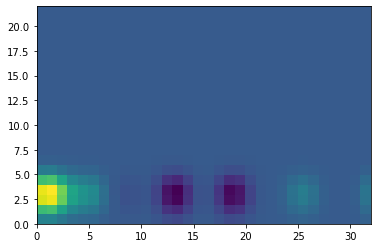

In [11]:
b = np.sum(np.array(client.gather([client.submit(worker, i, vec_krn, h, alpha) for i in range(len(pts))])), axis=0)
#for i in range(len(pts)):
#    worker(i, vec_krn, h, alpha)
plt.pcolormesh(b);